Import the necessary packages

In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import logging

In [ ]:
logging.basicConfig(filename='logs/model_development.txt',
					filemode='a',
					format='%(asctime)s %(message)s',
					datefmt="%Y-%m-%d %H:%M:%S")

In [ ]:
logging.warning("----------")
logging.warning("MODEL CREATION STAGE.......")

Load the dataset into a dataframe and display the first 5 rows of the dataframe

In [ ]:
logging.warning("Reading dataset..........")
df=pd.read_csv('/content/drive/MyDrive/UCI_Credit_Card.csv') ## give the link of the dataset
df.tail()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
29995,29996,220000.0,1,3,1,39,0,0,0,0,0,0,188948.0,192815.0,208365.0,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,0,0,1683.0,1828.0,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,0,0,3565.0,3356.0,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,0,-1,-1645.0,78379.0,76304.0,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1
29999,30000,50000.0,1,2,1,46,0,0,0,0,0,0,47929.0,48905.0,49764.0,36535.0,32428.0,15313.0,2078.0,1800.0,1430.0,1000.0,1000.0,1000.0,1


Extract the features and labels from the dataframe and print the shape of the feature set.

In [ ]:
logging.warning("Extract feature set and label.........")
X=df.iloc[:,1:-1]
y=df.iloc[:,-1]
X.shape

(30000, 23)

In [ ]:
## display the statistical characteristics of the dataset
logging.warning("get statistical characteristics.......")
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [ ]:
## converting marriage and education to categorical
logging.warning("Converting marriage and education fields into categorical........")
e1=pd.get_dummies(X['EDUCATION'],prefix='EDU')
m1=pd.get_dummies(X['MARRIAGE'],prefix='MAR')
X.drop(['EDUCATION','MARRIAGE'],axis=1,inplace=True)
X=pd.concat([X,e1,m1],axis=1)

The distribution of labels in the dataset helps to get information about the number of data in the two classes. 

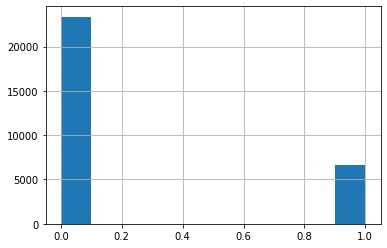

In [ ]:
## plot the histogram of labels in the dataset
logging.warning("Check distribution of classes.......")
df['default.payment.next.month'].hist()
plt.show()

As the labels are highly imbalance, apply SMOTE to balance the classes.

In [ ]:
from imblearn.over_sampling import SMOTE
logging.warning("Performing class balancing.........")
smote = SMOTE()
# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Split the dataset into train and test set with a split of 70% for training and 30% for testing.

In [ ]:
## train test split
logging.warning("Split data into train and test sets.......")
from sklearn.model_selection import train_test_split
(X_train,X_test,y_train,y_test)=train_test_split(x_smote,y_smote,test_size=0.3,random_state=42)
print(X_train.shape)
print(X_test.shape)

(32709, 32)
(14019, 32)


In [ ]:
!pip3 install catboost

In [ ]:
from sklearn.metrics import accuracy_score
logging.warning("Initializing classifier list...")
result=[]
clff=['Random Forest','Extra Tree','CatBoost']
classifiers=[RandomForestClassifier(n_estimators=150,max_depth=15,min_samples_split=2),
             ExtraTreesClassifier(n_estimators=150, max_depth=15,min_samples_split=2),
             CatBoostClassifier(random_state=42, silent=True)]
logging.warning("Classifier training and testing.....")
for clf in classifiers:
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  acc=accuracy_score(y_test,y_pred)
  result.append(acc)
logging.warning("Generating dataframe with classifier type and accuracy...")
out=pd.DataFrame(data={'classifier':clff,'accuracy':result})
print(out.head())


      classifier  accuracy
0  Random Forest  0.873029
1     Extra Tree  0.854911
2       CatBoost  0.875312


In [ ]:
## identify the best classifier
logging.warning("Identifying the best classifier model.....")
se=out['accuracy'].idxmax()
clf_sel=classifiers[se]
logging.warning("Best classifier fitting.....")
clf_sel.fit(X_train,y_train)

Print the classification report and confusion matrix to evaluate the classification system performance.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
logging.warning("Display classification report.....")
y_pred=clf_sel.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      7005
           1       0.93      0.81      0.87      7014

    accuracy                           0.88     14019
   macro avg       0.88      0.88      0.87     14019
weighted avg       0.88      0.88      0.87     14019

[[6603  402]
 [1346 5668]]


**Flask app development**

“Pickling” is the process whereby a Python object hierarchy is converted into a byte stream. The model is pickled as 'model' which is later loaded for app development. Create a new folder named 'templates' in the workspace. The app page design file is then stored as 'text3' in the folder.

In [ ]:
import pickle
logging.warning("Saving model...")
m1=clf_sel
pickle.dump(m1, open('model.pkl','wb'))